## Постановка проблемы:

Клиент, владеющий крупным производственным бизнесом, переживает о своей репутации в СМИ, поскольку это ощутимо влияет на продажи. Он хочет знать, как управлять репутацией с помощью искусственного интеллекта

## Задача:
1. Провести ознакомительный анализ данных
2. Идентифицировать возможные кейсы применения методов ML/NLP, которые помогут выполнить поставленную задачу
3. Выбрать один из кейсов и сделать простой прототип, который будет демонстрировать применение ML/NLP-инжиниринга в бизнес-задаче

## Решение задач

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import re
import yake
import spacy

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Считываем .csv-файл
df = pd.read_csv('labelled_newscatcher_dataset.csv', sep=';')

### 1. Ознакомительный анализ данных

In [3]:
# Наблюдаем шесть столбцов без пропусков со строчными форматами
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108774 entries, 0 to 108773
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   topic           108774 non-null  object
 1   link            108774 non-null  object
 2   domain          108774 non-null  object
 3   published_date  108774 non-null  object
 4   title           108774 non-null  object
 5   lang            108774 non-null  object
dtypes: object(6)
memory usage: 5.0+ MB


In [4]:
# Проверка на дубликаты
df.duplicated().sum()

0

In [5]:
# Проверка на пустые значения
print(df.isnull().sum())

topic             0
link              0
domain            0
published_date    0
title             0
lang              0
dtype: int64


In [6]:
# Из интересного - уникальных тем - 8, а язык - 1. В связи с этим, далее удалим столбец 'lang'
df.describe()

,topic,link,domain,published_date,title,lang
count,108774,108774,108774,108774,108774,108774
unique,8,106130,5164,68743,103180,1
top,TECHNOLOGY,https://www.google.com/,dailymail.co.uk,2020-08-04 01:00:00,"US tops 5 million confirmed virus cases, to Eu...",en
freq,15000,19,1855,41,21,108774


In [7]:
# Корректируем таблицу данных - удаляем ненужный столбец, приводим формат дат в нужный формат
data = df.copy().drop(columns='lang')

date_format = '%Y-%m-%d %H:%M:%S'
data['published_date'] = pd.to_datetime(data['published_date'], format=date_format)

data.head()

,topic,link,domain,published_date,title
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu..."
2,SCIENCE,https://www.express.co.uk/news/science/1322607...,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...
3,SCIENCE,https://www.ndtv.com/world-news/glaciers-could...,ndtv.com,2020-08-03 22:18:26,Glaciers Could Have Sculpted Mars Valleys: Study
4,SCIENCE,https://www.thesun.ie/tech/5742187/perseid-met...,thesun.ie,2020-08-12 19:54:36,Perseid meteor shower 2020: What time and how ...


In [8]:
data['published_date'].min()

Timestamp('2012-09-16 04:44:50')

In [9]:
data['published_date'].max()

Timestamp('2020-08-18 05:49:00')

In [10]:
topics_by_dt = data[['published_date', 'topic']].copy()
topics_by_dt['published_date'] = topics_by_dt['published_date'].dt.date

In [11]:
# Приводим формат дат для графика
topics_by_dt = data[['published_date', 'topic']].copy()
topics_by_dt['published_date'] = topics_by_dt['published_date'].dt.date

In [12]:
topics_by_dt = topics_by_dt.groupby(['published_date', 'topic']).size().unstack(fill_value=0)
topics_by_dt.head(3)

topic,BUSINESS,ENTERTAINMENT,HEALTH,NATION,SCIENCE,SPORTS,TECHNOLOGY,WORLD
published_date,,,,,,,,
2012-09-16,0,1,0,0,0,2,0,0
2015-10-23,0,0,0,0,1,0,0,0
2016-09-23,0,0,0,0,0,1,0,0


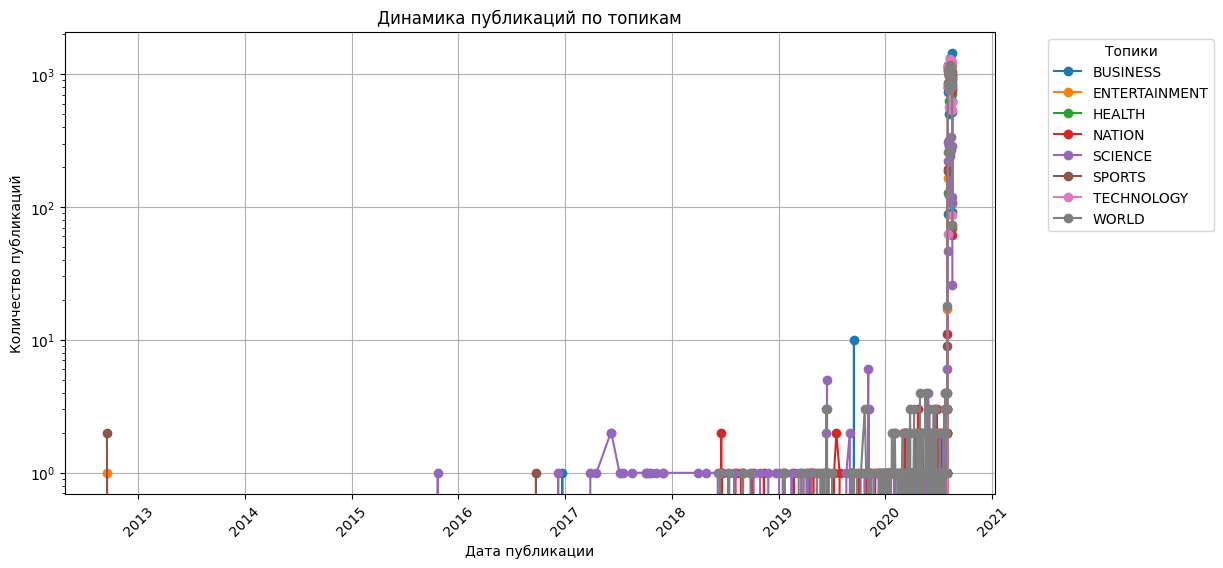

In [13]:
# По графику видно, что большинство публикации были в 2020 году.
plt.figure(figsize=(12, 6))
for topic in topics_by_dt.columns:
    plt.plot(topics_by_dt.index, topics_by_dt[topic], marker='o', linestyle='-', label=topic)

plt.yscale('log')
plt.xlabel("Дата публикации")
plt.ylabel("Количество публикаций")
plt.title("Динамика публикаций по топикам")
plt.xticks(rotation=45)
plt.legend(title="Топики", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [14]:
data["publish_day"] = pd.to_datetime(data["published_date"]).dt.date  # Убираем время
data["publish_day"] = pd.to_datetime(data["publish_day"])  # Приводим обратно к datetime64
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108774 entries, 0 to 108773
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   topic           108774 non-null  object        
 1   link            108774 non-null  object        
 2   domain          108774 non-null  object        
 3   published_date  108774 non-null  datetime64[ns]
 4   title           108774 non-null  object        
 5   publish_day     108774 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 5.0+ MB


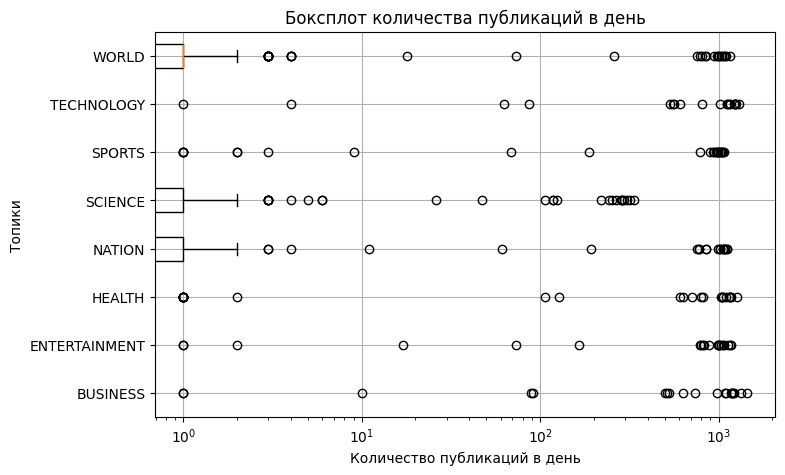

In [15]:
# Строим boxplot
# На основе графика мы видим очень большие выбросы по количеству публикаций в день во всех областях
# Основываясь на прошлом графике, построим еще два boxplot'а — до 2020-го года и с 2020-го года. 

plt.figure(figsize=(8, 5))
df_count = data.groupby(["publish_day", "topic"]).size().unstack(fill_value=0)

plt.boxplot(df_count, vert=False)
plt.yticks(ticks=range(1, len(df_count.columns) + 1), labels=df_count.columns)
plt.xscale('log')
plt.xlabel("Количество публикаций в день")
plt.ylabel("Топики")
plt.title("Боксплот количества публикаций в день")
plt.grid(True)
plt.show()

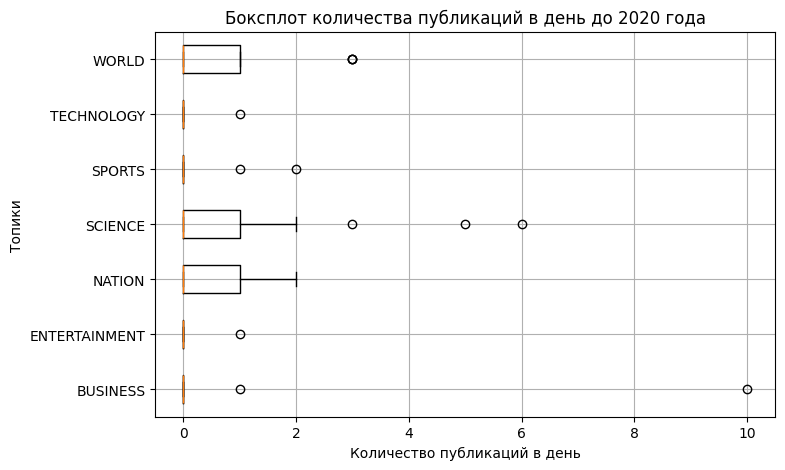

In [16]:
plt.figure(figsize=(8, 5))
df_count = data[data['publish_day']<pd.to_datetime('2020-01-01')].groupby(["publish_day", "topic"]).size().unstack(fill_value=0)

plt.boxplot(df_count, vert=False)
plt.yticks(ticks=range(1, len(df_count.columns) + 1), labels=df_count.columns)
plt.xlabel("Количество публикаций в день")
plt.ylabel("Топики")
#plt.xscale('log')
plt.title("Боксплот количества публикаций в день до 2020 года")
plt.grid(True)
plt.show()

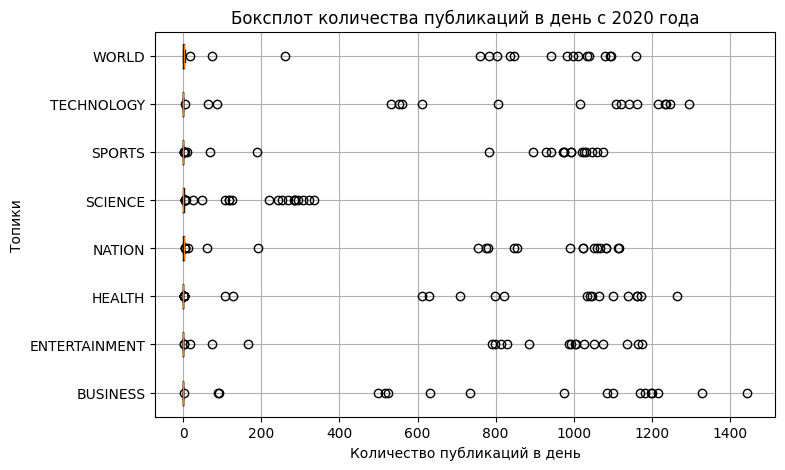

In [17]:
plt.figure(figsize=(8, 5))
df_count = data[data['publish_day']>=pd.to_datetime('2020-01-01')].groupby(["publish_day", "topic"]).size().unstack(fill_value=0)

plt.boxplot(df_count, vert=False)

plt.yticks(ticks=range(1, len(df_count.columns) + 1), labels=df_count.columns)

plt.xlabel("Количество публикаций в день")
plt.ylabel("Топики")
plt.title("Боксплот количества публикаций в день с 2020 года")

plt.grid(True)
plt.show()

In [18]:
# Приводим publish_day к формату YYYY-MM (год-месяц)
data["publish_month"] = data["publish_day"].astype(str).str[:7]

In [19]:
# Разбив данные по количеству публикаций в месяц, определяем что 99.6% всех данных приходится на 2020-08
print(data['publish_month'].value_counts().head(3))
print()
print(data['publish_month'].value_counts(normalize=True).head(3))

publish_month
2020-08    108315
2020-07        86
2020-06        49
Name: count, dtype: int64

publish_month
2020-08    0.995780
2020-07    0.000791
2020-06    0.000450
Name: proportion, dtype: float64


In [20]:
# Рассмотрим данные за август - 
data[data['publish_day']>= pd.to_datetime('2020-08')]['publish_day'].value_counts().sort_index()

publish_day
2020-08-01      68
2020-08-02    1133
2020-08-03    5842
2020-08-04    8139
2020-08-05    7534
2020-08-06    7848
2020-08-07    7376
2020-08-08    5165
2020-08-09    5562
2020-08-10    8210
2020-08-11    8199
2020-08-12    8197
2020-08-13    8141
2020-08-14    7735
2020-08-15    5148
2020-08-16    5376
2020-08-17    8055
2020-08-18     587
Name: count, dtype: int64

In [21]:
# Количество публикаций 2020-08-01 относительно других дней месяца несоизмеримо малы
# Проверим день на постоянтство притока данных - судя по отрезкам между первым и последним поступлением, будем считать что поток был корректен
print(data[data['publish_day'] == pd.to_datetime('2020-08-01')]['published_date'].min())
print()
print(data[data['publish_day'] == pd.to_datetime('2020-08-01')]['published_date'].max())

2020-08-01 00:30:28

2020-08-01 23:54:06


In [22]:
# Заметили, что за 2020-08-18 данных за весь день не хватает - есть только за четверть дня
# в дальнейшей обработке месяца исключим данный день
print(data[data['publish_day'] == pd.to_datetime('2020-08-18')]['published_date'].min())
print()
print(data[data['publish_day'] == pd.to_datetime('2020-08-18')]['published_date'].max())

2020-08-18 00:00:00

2020-08-18 05:49:00


In [23]:
# Удаляем день
data = data[data['publish_day']!='2020-08-18']

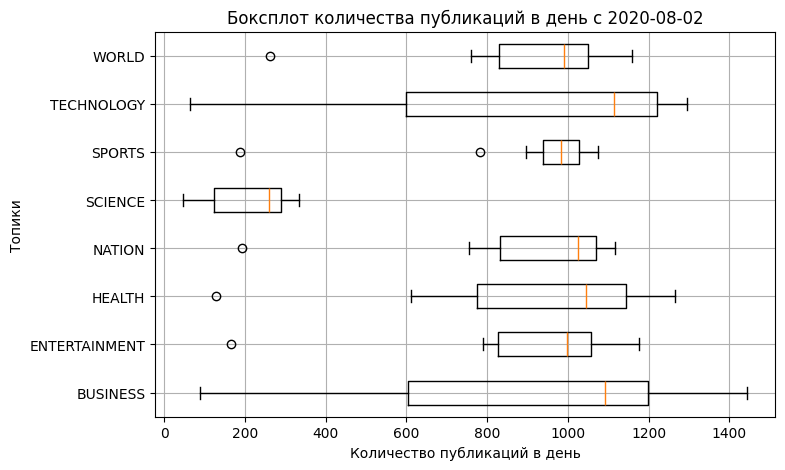

topic,BUSINESS,ENTERTAINMENT,HEALTH,NATION,SCIENCE,SPORTS,TECHNOLOGY,WORLD
count,16.000000,16.000000,16.00000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,931.062500,931.625000,930.12500,926.062500,225.500000,931.937500,931.750000,920.687500
std,381.418487,240.537419,296.73532,233.942007,91.290744,210.838475,363.470402,215.226925
min,89.000000,166.000000,127.00000,192.000000,47.000000,188.000000,63.000000,261.000000
25%,604.500000,826.000000,775.75000,831.250000,122.500000,938.250000,599.250000,828.750000
50%,1092.500000,997.500000,1044.00000,1024.000000,260.500000,984.000000,1115.500000,991.500000
75%,1197.750000,1058.250000,1144.50000,1071.000000,288.000000,1028.250000,1220.000000,1049.750000
max,1444.000000,1176.000000,1265.00000,1116.000000,334.000000,1075.000000,1295.000000,1160.000000


In [24]:
# Судя по графику можем сделать вывод о равномерности количества публикаций — видимых выбросов нет

plt.figure(figsize=(8, 5))
df_count = data[data['publish_day']>=pd.to_datetime('2020-08-02')].groupby(["publish_day", "topic"]).size().unstack(fill_value=0)

plt.boxplot(df_count, vert=False)

plt.yticks(ticks=range(1, len(df_count.columns) + 1), labels=df_count.columns)

plt.xlabel("Количество публикаций в день")
plt.ylabel("Топики")
plt.title("Боксплот количества публикаций в день с 2020-08-02")

plt.grid(True)
plt.show()

display(df_count.describe())

In [25]:
topics_by_dt = data[['publish_day', 'topic']].copy()

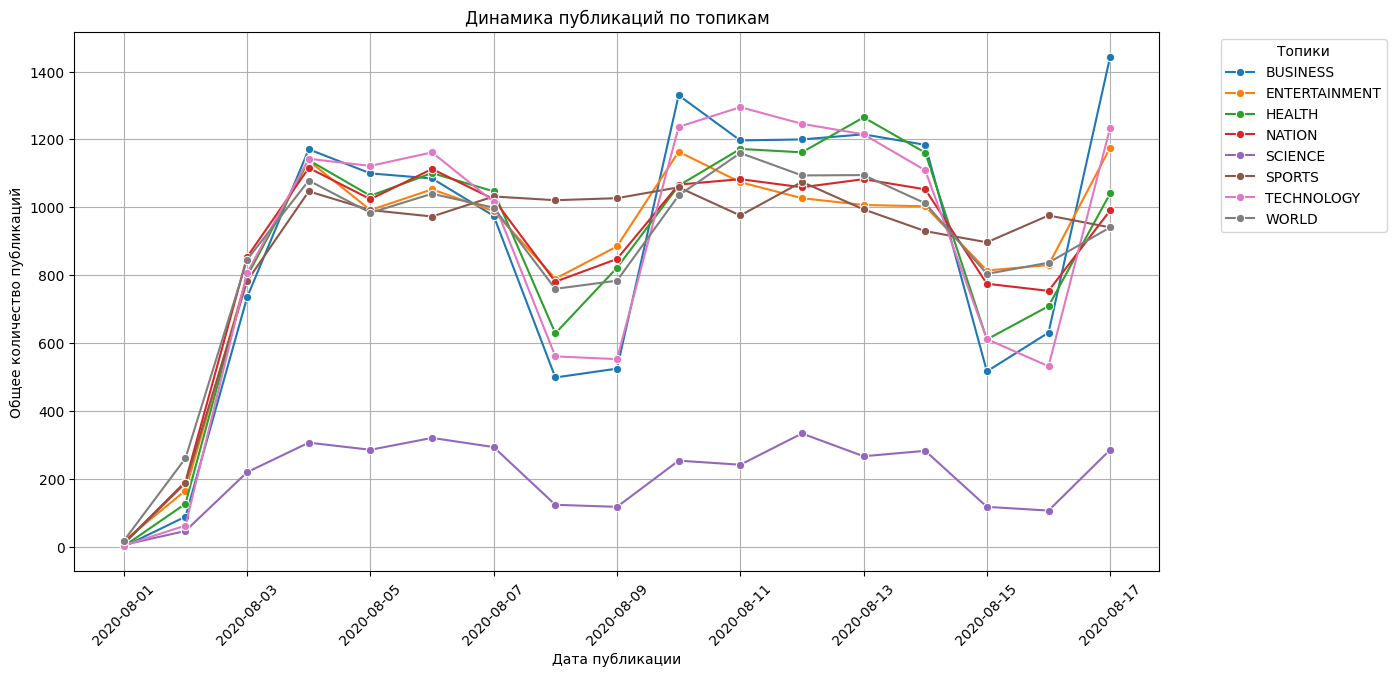

In [26]:
# График публикаций по темам
topics_count = topics_by_dt[topics_by_dt['publish_day']>=pd.to_datetime('2020-08-01')].groupby(['publish_day', 'topic']).size().reset_index(name='count')

# Убедимся, что publish_day в формате datetime
topics_count['publish_day'] = pd.to_datetime(topics_count['publish_day'])

# Группируем данные по дате и теме, суммируем количество публикаций
df_grouped = topics_count.groupby(['publish_day', 'topic'])['count'].sum().reset_index()

# Построение линейного графика
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_grouped, x='publish_day', y='count', hue='topic', marker='o')

# Оформление графика
plt.xlabel("Дата публикации")
plt.ylabel("Общее количество публикаций")
plt.title("Динамика публикаций по топикам")
plt.xticks(rotation=45)
plt.legend(title="Топики", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()


In [27]:
# Проверим такие же данные в августе 2020 года
# Необходимо проверить публикации по доменам - на наличие выбросов/артефактных значений

pubs_by_domain_aug = data[data['publish_month']=='2020-08']['domain'].value_counts().reset_index()

conditions = [
     pubs_by_domain_aug['count'] <= 1,
     pubs_by_domain_aug['count'] < 5,
     pubs_by_domain_aug['count'] < 50,
     pubs_by_domain_aug['count'] < 100,
     pubs_by_domain_aug['count'] < 500,
     pubs_by_domain_aug['count'] < 1000
     ]

choices = [
    '1',
    '< 5',
    '< 50',
    '< 100',
    '< 500',
    '< 1000'
]

pubs_by_domain_aug['cnt_cat'] = np.select(conditions, choices, default='>= 1000')

print(pubs_by_domain_aug['cnt_cat'].value_counts())
print()
print(pubs_by_domain_aug['cnt_cat'].value_counts(normalize=True))
print()
print(f"Публикаций: {sum(pubs_by_domain_aug['count'])}")

cnt_cat
1          1762
< 50       1499
< 5        1462
< 500       204
< 100       179
< 1000       23
>= 1000       6
Name: count, dtype: int64

cnt_cat
1          0.343135
< 50       0.291918
< 5        0.284713
< 500      0.039727
< 100      0.034859
< 1000     0.004479
>= 1000    0.001168
Name: proportion, dtype: float64

Публикаций: 107728


In [28]:
# Проверим такие же данные без августа 2020 года
# Необходимо проверить публикации по доменам - на наличие выбросов/артефактных значений

pubs_by_domain_not_aug = data[data['publish_month']!='2020-08']['domain'].value_counts().reset_index()

conditions = [
     pubs_by_domain_not_aug['count'] <= 1,
     pubs_by_domain_not_aug['count'] < 5,
     pubs_by_domain_not_aug['count'] < 50,
     pubs_by_domain_not_aug['count'] < 100,
     pubs_by_domain_not_aug['count'] < 500,
     pubs_by_domain_not_aug['count'] < 1000
     ]

choices = [
    '1',
    '< 5',
    '< 50',
    '< 100',
    '< 500',
    '< 1000'
]

pubs_by_domain_not_aug['cnt_cat'] = np.select(conditions, choices, default='>= 1000')

print(pubs_by_domain_not_aug['cnt_cat'].value_counts())
print()
print(pubs_by_domain_not_aug['cnt_cat'].value_counts(normalize=True))
print()
print(f"Публикаций: {sum(pubs_by_domain_not_aug['count'])}")

cnt_cat
1        51
< 5      23
< 50     16
< 100     2
Name: count, dtype: int64

cnt_cat
1        0.554348
< 5      0.250000
< 50     0.173913
< 100    0.021739
Name: proportion, dtype: float64

Публикаций: 459


#### Выводы

На основании предобработки данных сделали следующие выводы:
1. Имеются данные о публикациях в период с 2012-09-16 - 2020-08-17.
2. 99.5% данных приходится на август 2020 года.
3. Связи между количеством публикаций и доменами, при данной глубине поиска, найдено не было

Принятые решения:
1. В связи с дисбалансом количества данных, исследование будет проводиться на данных августа 2020 года

### 2. Идентифицикация кейсов применения методов ML/NLP

Возможные методы NLP для данной бизнес-задачи:

- Определение тональности&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;— положительный, отрицательный или нейтральный текст
- Классификация по темам &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;— распределение публикаций по категориям (внутри уже существующих топиков)
- Анализ трендов и аномалий&nbsp;&nbsp;&nbsp;— определение внимания к определенным темам
- Извлечение ключевых слов&nbsp;&nbsp;&nbsp; — определение важных упоминаний (имена, бренды и т.д.)
- Определение фейков
 
 
В связи с тем, что наш клиент хочет знать о репутации в СМИ, будем использовать, на основе заголовков статей, **определение тональности, классификацию новостей по темам и извлечение ключевых слов**.

P.S. основываемся лишь на заголовках, а не самих статьях в целях простоты работы и в качестве демонстрации применяемых методов

### 3. Создание простого прототипа с применением ML/NLP-инжиниринга в бизнес-задаче

In [29]:
# Создадим функцию подготовки текста к работе - удаляем лишние символы, лемматизируем слова.

# Создание списка стоп-слов
stop_words = stopwords.words('english')

def prepare_text(text):
    txt = text.lower()
    txt = re.sub(r'[^a-z\s]', '', txt)

    tokenized = word_tokenize(txt)

    wnl = WordNetLemmatizer()

    lemm_text = [wnl.lemmatize(word) for word in tokenized if word not in stop_words]

    return ' '.join(lemm_text)

In [30]:
# Создаем наблюдаемый, для задачи, датасет
data_obs = data[data['publish_month']=='2020-08'][['topic', 'domain', 'published_date', 'title']]
data_obs.head(3)

,topic,domain,published_date,title
0,SCIENCE,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...
1,SCIENCE,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu..."
2,SCIENCE,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...


In [31]:
data_obs['title_prep'] = data['title'].apply(prepare_text)

In [32]:
data_obs.head(3)

,topic,domain,published_date,title,title_prep
0,SCIENCE,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,closer look watersplittings solar fuel potential
1,SCIENCE,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",irresistible scent make locust swarm study find
2,SCIENCE,express.co.uk,2020-08-13 21:01:00,Artificial intelligence warning: AI will know ...,artificial intelligence warning ai know u bett...


#### 3.1. Определение тональности

sentiment
neutral     42519
positive    33176
negative    32033
Name: count, dtype: int64


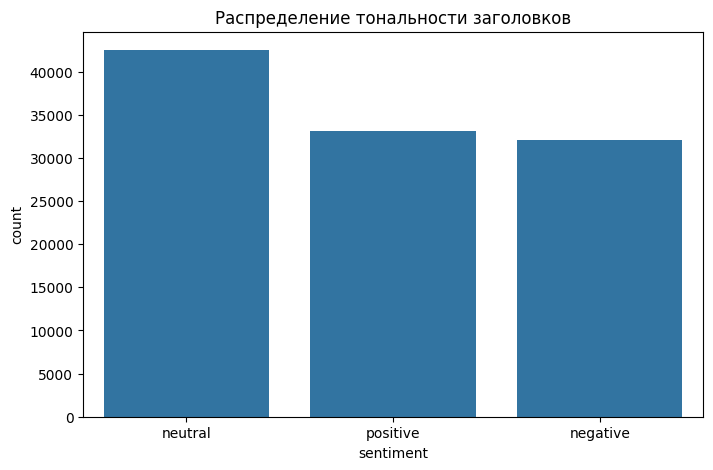

In [36]:
analyzer = SentimentIntensityAnalyzer()

# Определяем тональность заголовков
data_obs['sentiment_score'] = data_obs['title_prep'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Классифицируем по тональности
data_obs['sentiment'] = data_obs['sentiment_score'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

# Смотрим распределение тональности
print(data_obs['sentiment'].value_counts())

plt.figure(figsize=(8,5))
sns.countplot(x=data_obs['sentiment'])
plt.title("Распределение тональности заголовков")
plt.show()

#### 3.2. Извлечение ключевых слов.

In [37]:
kw_extractor = yake.KeywordExtractor(lan="en", n=1, top=3)

data_obs['keywords'] = data_obs['title_prep'].apply(lambda x: ", ".join([kw[0] for kw in kw_extractor.extract_keywords(x)]))

In [38]:
# Посмотрим первые 5 примеров
display(data_obs[['topic','title_prep', 'keywords']].head())

,topic,title_prep,keywords
0,SCIENCE,closer look watersplittings solar fuel potential,"closer, potential, watersplittings"
1,SCIENCE,irresistible scent make locust swarm study find,"irresistible, find, scent"
2,SCIENCE,artificial intelligence warning ai know u bett...,"artificial, intelligence, warning"
3,SCIENCE,glacier could sculpted mar valley study,"glacier, study, sculpted"
4,SCIENCE,perseid meteor shower time see huge bright fir...,"perseid, tonight, meteor"


#### Выводы

В данном проекте были применены два подхода к статьям - определение тональности и выражение ключевых слов в названиях статей.
Возможности улучшения для клиента:
- отбор интересующих тем по ключевым словам и тональностям
- парсинг всего текста в отобранных статьях
- применение на этих текстах моделей (возможны улучшения в виде TF-IDF для оценки веса слов в статье, применение методики BERT)
